In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from simtk import unit
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import simtk.openmm as mm

# Umbrella Sampling

## Sistema de tests: Doble pozo

In [3]:
from uibcdf_test_systems import DoubleWell
from uibcdf_test_systems.simulation import langevin_NVT
from uibcdf_test_systems.analysis import probability_density

In [4]:
# Parametros del sistema y el potencial
m = 14.007 * unit.amu
Eo = 4.0 * unit.kilocalories_per_mole
a = 1.0 * unit.nanometers
b = 0.25 * unit.kilocalories_per_mole

# Sistema
double_well_asymmetric = DoubleWell(n_particles = 1, mass = m, Eo = Eo, a = a, b = b)

In [5]:
# Parametros del estado termodinámico
T = 300*unit.kelvin

# Condiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

# Simulación
times, positions, _, _, _ = langevin_NVT (double_well_asymmetric.system, temperature = T,
                                          friction = 1.0/unit.picoseconds,
                                          initial_positions = initial_positions,
                                          initial_velocities = initial_velocities,
                                          integration_timestep = 0.2 * unit.picoseconds,
                                          saving_timestep = 10.0 * unit.picoseconds,
                                          total_time = 0.3 * unit.microseconds)

100%|██████████| 29999/29999 [00:49<00:00, 611.65it/s]


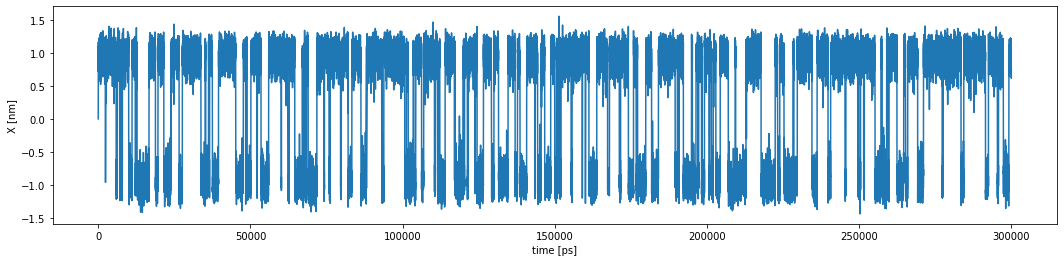

In [6]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,positions[:,0,0])
plt.ylabel('X [{}]'.format(positions.unit.get_symbol()))
plt.xlabel('time [{}]'.format(times.unit.get_symbol()))
plt.show()

In [7]:
prob_density, coors_x, bins, delta_x = probability_density (positions[:,0,0], [-2.0,2.0]*unit.nanometers, 400)
prob_density_teo, _, _, _ = probability_density (double_well_asymmetric, [-2.0,2.0]*unit.nanometers, 400, T)

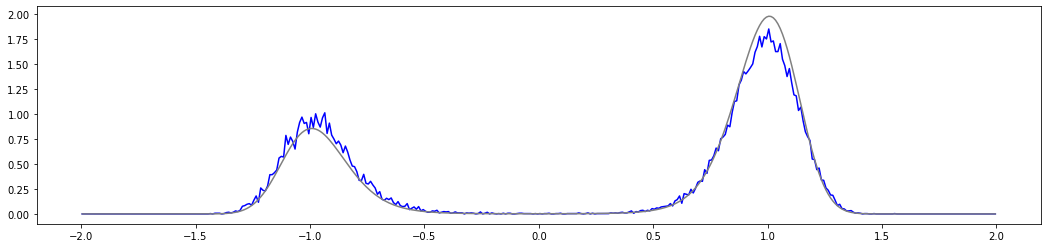

In [8]:
plt.plot(coors_x, prob_density, color='blue')
plt.plot(coors_x, prob_density_teo, color='gray')
plt.show()

## Umbrellas

In [9]:
limite_inferior_x = -1.5*unit.nanometers
limite_superior_x = 1.5*unit.nanometers
n_umbrellas = 50

centros = np.zeros([n_umbrellas,3]) * unit.nanometers
centros[:,0] = np.linspace(limite_inferior_x._value, limite_superior_x._value, n_umbrellas, endpoint=True)*unit.nanometers

ks = np.repeat(30.0, n_umbrellas) * unit.kilocalories_per_mole/ unit.nanometers**2

In [13]:
from copy import deepcopy
import simtk.openmm as mm
from tqdm import tqdm

trayectorias_umbrellas = []

for ii in tqdm(range(n_umbrellas)):
    
    system = deepcopy(double_well_asymmetric.system)
    
    centro = centros[ii]
    k = ks[ii]
    
    force = mm.CustomExternalForce('0.5*k*(x-xo)^2')
    force.addGlobalParameter('k', k)
    force.addGlobalParameter('xo', centro[0])
    for ii in range(double_well_asymmetric.n_particles):
        force.addParticle(ii, [])
    system.addForce(force)
    
    initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
    initial_positions[0,:] = centro
    initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
    
    times, positions, _, _, _ = langevin_NVT (system, temperature = T,
                                              friction = 1.0/unit.picoseconds,
                                              initial_positions = initial_positions,
                                              initial_velocities = initial_velocities,
                                              integration_timestep = 0.1 * unit.picoseconds,
                                              saving_timestep = 2.0 * unit.picoseconds,
                                              total_time = 400.0 * unit.picoseconds,
                                              verbose=False)
    
    trayectorias_umbrellas.append(positions)
    

100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


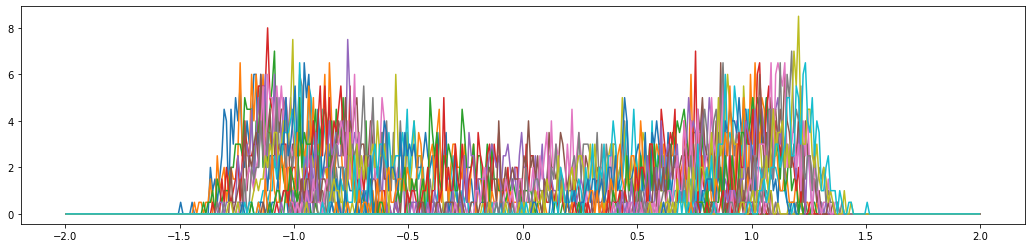

In [19]:
for ii in range(n_umbrellas):
    prob_density, coors_x, _, _ = probability_density (trayectorias_umbrellas[ii][:,:,0], [-2.0,2.0]*unit.nanometers, 400)
    plt.plot(coors_x, prob_density)

## Notas
- Tiene la ventaja de que podemos ir añadiendo umbrellas sobre el set inicial para refinar el resultado o hacer que converja más rapidamente o mejor
- Se puede combinar con otras técnicas de sampleado, incluso con markov state models